In [3]:
#Importing required modules.
import pandas as pd
import matplotlib.pyplot as plt
from rootpath import detect

In [4]:
#Getting path of data file.
basePath = detect()
dataPath = basePath + '/bank-full.csv'

In [5]:
#Reading data into a dataframe, since data is pretty small we should have no memory problems.
dataDF = pd.read_csv(dataPath, sep = ';')
#Checking the DF
dataDF.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


For reference:

## Bank client data:

   *  age (numeric)
   *  job : type of job (categorical:"admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
   *  marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   *  education (categorical: "unknown","secondary","primary","tertiary")
   *  default: has credit in default? (binary: "yes","no")
   *  balance: average yearly balance, in euros (numeric) 
   *  housing: has housing loan? (binary: "yes","no")
   *  loan: has personal loan? (binary: "yes","no")

## Related with the last contact of the current campaign:

   *  contact: contact communication type (categorical: "unknown","telephone","cellular") 
   *  day: last contact day of the month (numeric)
   *  month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   *  duration: last contact duration, in seconds (numeric)
   
## Other attributes:

   *  campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
   *  pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
   *  previous: number of contacts performed before this campaign and for this client (numeric)
   *  poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

## Output variable (desired target):

   *  has the client subscribed a term deposit? (binary: "yes","no")


## Question 1: Which job is more likely to make a loan? Of which type?

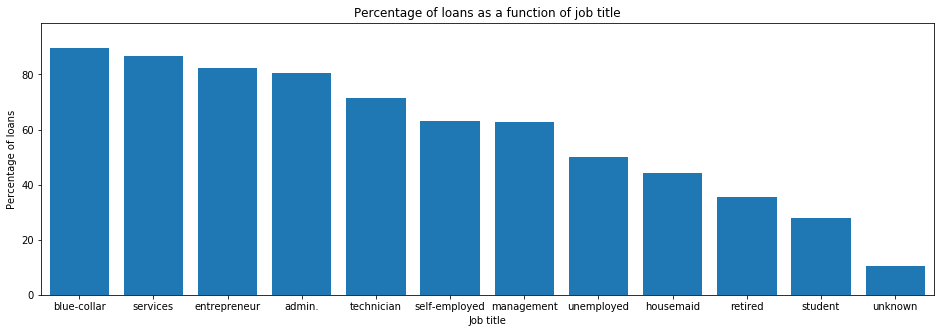

In [98]:
#Looking at main statistics for housing and personal loans
groupedByDF = dataDF[['job','housing']].groupby(['job']).agg({'housing': 'count'}).reset_index().\
                        rename({'housing': 'total_per_job'}, axis = 1)
groupedByDFHousing = dataDF.loc[dataDF['housing']=='yes',['job', 'housing']].\
                        groupby(['job']).agg({'housing': 'count'})
groupedByDFLoan = dataDF.loc[dataDF['loan']=='yes',['job', 'loan']].\
                        groupby(['job']).agg({'loan': 'count'})

groupedByDF = groupedByDF.join(groupedByDFHousing, on = 'job', how = 'inner')
groupedByDF = groupedByDF.join(groupedByDFLoan, on = 'job', how = 'inner')

groupedByDF['housing_percentage'] = (groupedByDF['housing'] / groupedByDF['total_per_job'])*100
groupedByDF['loan_percentage'] = (groupedByDF['loan'] / groupedByDF['total_per_job'])*100
groupedByDF['total_number'] = groupedByDF['loan'] + groupedByDF['housing']
groupedByDF['total_percentage'] = ((groupedByDF['loan'] + groupedByDF['housing']) / groupedByDF['total_per_job'])*100

#Showing results ordered by percentage of loans
groupedByDF = groupedByDF.sort_values('total_percentage', ascending = False)

plt.figure(figsize=(16, 5))
plt.margins(x=0.01,y=0.1)
plt.bar(groupedByDF['job'],groupedByDF['total_percentage'])
plt.title("Percentage of loans as a function of job title")
plt.xlabel('Job title')
plt.ylabel('Percentage of loans')
plt.show()

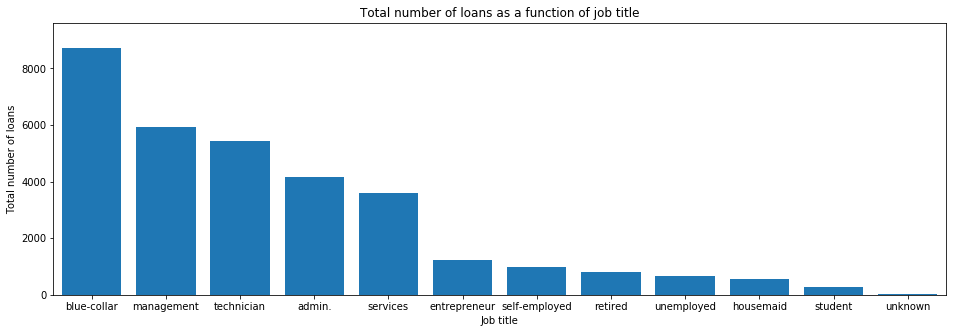

In [99]:
#Showing results ordered by total number of loans
groupedByDF = groupedByDF.sort_values('total_number', ascending = False)
plt.figure(figsize=(16, 5))
plt.margins(x=0.01,y=0.1)
plt.bar(groupedByDF['job'],groupedByDF['total_number'])
plt.title("Total number of loans as a function of job title")
plt.xlabel('Job title')
plt.ylabel('Total number of loans')
plt.show()

By aggregating the results as shown above, we can see that the blue-collar profession is the one with the highest number of successful loans, both in number and percentage. Therefore, a blue-collar is more likely to order a loan than other customers from other jobs. In order to know which type of loan blue-collar customers prefer, let's look at the grouped dataframe.

In [100]:
groupedByDF

,job,total_per_job,housing,loan,housing_percentage,loan_percentage,total_number,total_percentage
1,blue-collar,9732,7048,1684,72.420880,17.303740,8732,89.724620
4,management,9458,4678,1253,49.460774,13.248044,5931,62.708818
9,technician,7597,4115,1309,54.166118,17.230486,5424,71.396604
0,admin.,5171,3182,991,61.535486,19.164572,4173,80.700058
7,services,4154,2766,836,66.586423,20.125181,3602,86.711603
2,entrepreneur,1487,869,356,58.439812,23.940820,1225,82.380632
6,self-employed,1579,765,229,48.448385,14.502850,994,62.951235
5,retired,2264,491,309,21.687279,13.648410,800,35.335689
10,unemployed,1303,543,109,41.673062,8.365311,652,50.038373
3,housemaid,1240,398,152,32.096774,12.258065,550,44.354839


The type of loan preferred by blue-collars is housing loans, which 72% of blue-collar customers in this database order as a bank product.

## Question 2: Observing the variables 'number of contacts for a given campaign' and 'campaign success', what are the main relevant points?

In [161]:
groupedByCampaign = dataDF[['poutcome','housing']].groupby(['poutcome']).count().reset_index().\
                        rename({'housing': 'count'}, axis = 1)
groupedByCampaign

,poutcome,count
0,failure,4901
1,other,1840
2,success,1511
3,unknown,36959


The first thing we can see here is that most of the records in this database have an unknown outcome of campaign. This means that those records will not aid us in understanding the relevant characteristics relating number of contacts and campaign success. Let's look at some statistics for the number of contacts related to success and failure outcomes.

In [313]:
perc = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
numberOfContactsStatistics = dataDF.loc[dataDF['poutcome']=='success',['poutcome','previous']].describe(percentiles = perc).\
                    rename({'previous' : 'success_label'}, axis = 1)
numberOfContactsStatistics['failure_label'] = dataDF.loc[dataDF['poutcome']=='failure',['poutcome','previous']].\
                    describe(percentiles = perc)
numberOfContactsStatistics

,success_label,failure_label
count,1511.000000,4901.000000
mean,3.075447,2.896552
std,2.593854,3.130252
min,1.000000,1.000000
10%,1.000000,1.000000
20%,1.000000,1.000000
30%,1.000000,1.000000
40%,2.000000,2.000000
50%,2.000000,2.000000
60%,3.000000,2.000000


Percentiles look pretty similar. However, notice that the max value for failure outcomes is almost double of the max value for success outcomes. Let's take a better look at this.

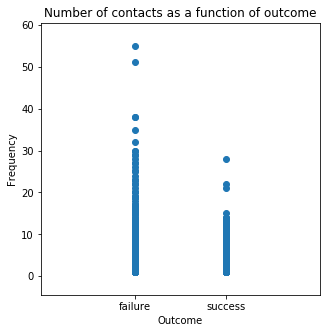

In [294]:
filteredDF = dataDF[(dataDF['poutcome']=='success') | (dataDF['poutcome']=='failure')]

plt.figure(figsize=(5, 5))
plt.scatter(filteredDF['poutcome'].astype(str), filteredDF['previous'])
plt.margins(x=1,y=0.1)
plt.title("Number of contacts as a function of outcome")
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.show()

It appears that an increased number of calls increases the likelihood of failure outcome. It seems that 15 attempts of contact is a good threshold for call success. Let's try to make this more precise.

In [291]:
largeCallsDF = dataDF[(dataDF['previous'] >=15) & (dataDF['poutcome'].isin(['success','failure']))][['previous','poutcome']].\
                         groupby('poutcome').count().reset_index().rename({'previous': 'count'},axis = 1)
largeCallsDF

,poutcome,count
0,failure,57
1,success,4


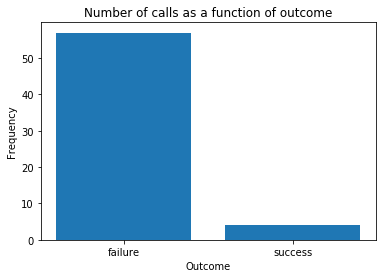

In [293]:
plt.bar(largeCallsDF['poutcome'],largeCallsDF['count'])
plt.title("Number of calls as a function of outcome")
plt.xlabel('Outcome')
plt.ylabel('Frequency')
plt.show()

At 15 seconds or longer, only about 6% of the calls result in success. Also, from the "Call duration as a function of outcome" graph, we can see that the number of samples with a success outcome decreases as the call duration increases. Therefore, we can conclude that more succinct calls are preferred by customers when it comes to campaign success. Let's take a look if the customers's job title can influence campaign success when related to number of contacts.  

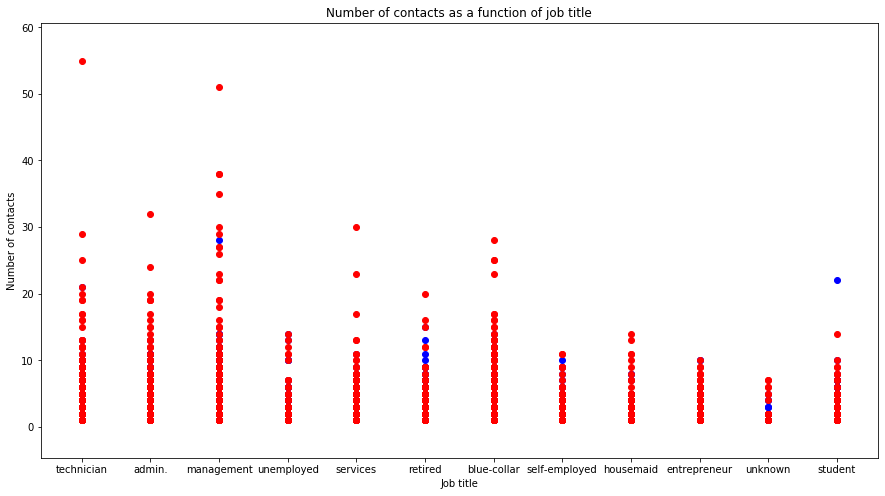

In [305]:
plt.figure(figsize=(15, 8))

plt.scatter(dataDF[dataDF['poutcome']=='success']['job'].astype(str), dataDF[dataDF['poutcome']=='success']['previous'],color='blue')
plt.scatter(dataDF[dataDF['poutcome']=='failure']['job'].astype(str), dataDF[dataDF['poutcome']=='failure']['previous'],color='red')
plt.margins(x=0.05,y=0.1)
plt.title("Number of contacts as a function of job title")
plt.xlabel('Job title')
plt.ylabel('Number of contacts')
plt.show()

Notice how success outcome presence diminishes as number of calls increase. The job title versus number of calls only seem to corroborate with the analysis above: high number of contacts should be avoided. Another factor that would be interesting to analyze is type of contact in relation to number of contacts: do customers that are contacted by cellular are more tolerant to longer calls than customers contacted by telephone, or vice versa? I will leave this out for time restrictions.

## Question 3: Using the outcome of results from the campaign, what is the average and maximum number of call you would recommend to optimize positive results?

In [315]:
#Revisiting the statistics of number of contacts:
numberOfContactsStatistics

,success_label,failure_label
count,1511.000000,4901.000000
mean,3.075447,2.896552
std,2.593854,3.130252
min,1.000000,1.000000
10%,1.000000,1.000000
20%,1.000000,1.000000
30%,1.000000,1.000000
40%,2.000000,2.000000
50%,2.000000,2.000000
60%,3.000000,2.000000


Based on the percentiles for success and failure outcomes, I would say that keeping contacts at a 3-4 count, since we had 70%-80% of success outcomes equal or lower than this rate of contacts. Besides, the mean of the number of contacts with success outcomes is 3, which also indicates that this is a good number of contacts range.

## Question 4: Are the last campaigns results relevant to the current campaign?

##  Question 5: What is the determining factor for the bank to demand that the client have credit insurance? 

Credit insurance is most likely demanded by the bank if the client is prone to defaulting on a loan. By inspecting the dataset, we can see there is information on the default scenario of the clients (whether he has credit in default or not - 'yes' or 'no'). However, we don't know which variables better predict whether the client will default or not. Let's take a look at statistics for the numerical variables and see if we can spot any trends.

In [76]:
testDF = dataDF[dataDF['default']=='yes']
testDF.describe(percentiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

,age,balance,day,duration,campaign,pdays,previous
count,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000,815.000000
mean,39.534969,-137.624540,16.385276,239.115337,3.148466,18.042945,0.268712
std,9.357804,906.704678,8.564183,214.512375,3.628145,73.651493,1.629787
min,21.000000,-8019.000000,1.000000,3.000000,1.000000,-1.000000,0.000000
10%,28.000000,-736.000000,5.000000,53.800000,1.000000,-1.000000,0.000000
20%,31.000000,-435.000000,7.000000,84.000000,1.000000,-1.000000,0.000000
30%,33.000000,-249.800000,10.000000,114.000000,1.000000,-1.000000,0.000000
40%,35.000000,-103.400000,14.000000,139.000000,2.000000,-1.000000,0.000000
50%,38.000000,-7.000000,17.000000,172.000000,2.000000,-1.000000,0.000000
60%,41.000000,0.000000,19.000000,213.400000,2.000000,-1.000000,0.000000


In [77]:
testDF = dataDF[dataDF['default']=='no']
testDF.describe(percentiles = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

,age,balance,day,duration,campaign,pdays,previous
count,44396.000000,44396.000000,44396.000000,44396.000000,44396.000000,44396.000000,44396.000000
mean,40.961934,1389.806424,15.795792,258.512749,2.756780,40.604536,0.586044
std,10.638882,3063.275425,8.317696,258.239396,3.087038,100.504630,2.313596
min,18.000000,-4057.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
10%,29.000000,0.000000,5.000000,58.000000,1.000000,-1.000000,0.000000
20%,32.000000,31.000000,7.000000,89.000000,1.000000,-1.000000,0.000000
30%,34.000000,144.000000,10.000000,117.000000,1.000000,-1.000000,0.000000
40%,36.000000,285.000000,13.000000,147.000000,2.000000,-1.000000,0.000000
50%,39.000000,468.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
60%,42.000000,722.000000,18.000000,223.000000,2.000000,-1.000000,0.000000


Out of the start, we can see that 90% of people who default have average yearly balance smaller than 200.40 euros, while only 30%-40% of people that do not default have such small balance. This may indicate that balance has a strong importance in predicting if the bank should demand credit insurance or not.

In order to take a look at variable importance, let's try to predict default using the available variables. In this case, I will use a Random Forest ensemble model, because it is more robust than simple Decision Trees, is of easy implementation and it readily accepts categorical and numerical variables without many transformations (for instance, feature rescaling). Besides, we can use the normalized Gini impurity of all trees in the forest to classify variable importance and understand which variables best predict default. 

In [81]:
#Importing modules needed for this question
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [86]:
#Encoding categorical variables
categoricalVariables = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

#Taking out column to be predicted
x = dataDF.drop('default', axis=1)

#Store all LabelEncoder() transformations in case we need to inverse transform the encoding of the variables
dictEncoder = {}

for item in categoricalVariables:
    dictEncoder[item] = LabelEncoder()
    dictEncoder[item].fit(x[item])
    x[item] = dictEncoder[item].transform(x[item])

#Separating column to be predicted
y = dataDF['default']

#Separating test and train data to evaluate model accuracy. Using 20% of the data as test data, I am not sure if this is
#the ideal number, just a guess. Seems to work fine.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=29301)

#Training model
forest = ExtraTreesClassifier(n_estimators=200,random_state=0)
forest.fit(x_train, y_train)

#Looking at the accuracy of the model on test data
print("The accuracy of this model for the test data is: " + str(100*forest.score(x_test,y_test)) + "%")

The accuracy of this model for the test data is: 98.28596704633418%


We can see that the model is accurate. Now let's look at the variable importance.

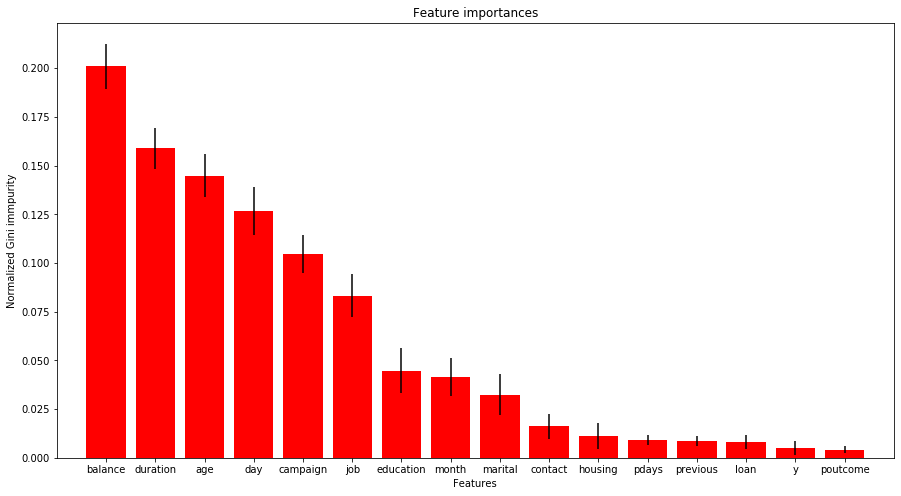

In [88]:
#Getting Gini impurity from trees in the forest
importances = forest.feature_importances_
stdeviation = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

#Converting indices to names of variables for interpretation
listOfVariables = list(x)
namedIndices = [listOfVariables[item] for item in indices]

#Plotting normalized Gini impurity for each variable normalized using values from all trees in the forest
plt.figure(figsize=(15, 8))
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="r", yerr=stdeviation[indices], align="center")
plt.xticks(range(x.shape[1]), namedIndices)
plt.xlim([-1, x.shape[1]])
plt.xlabel('Features')
plt.ylabel('Normalized Gini immpurity')
plt.show()

As we suspected, balance is the most important feature for default prediction. From our earlier analysis, it seems that low average yearly balance is grounds for the bank to demand credit insurance. Of course, other variables were indicated as important for default prediction, like age and job, so there is no unique factor that would predict default by itself. The next step using this model would be to look at the decision trees inside our ensemble to better understand the profile of defaulters.

## Question 6: What are the most relevant characteristics of clients who have a personal loan?